In [2]:
! git clone https://github.com/harsh098/ransomware-classifier


Cloning into 'ransomware-classifier'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 37 (delta 18), reused 37 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 14.34 MiB | 12.96 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [3]:
! cp -r ransomware-classifier/logs ./logs
! cp -r ransomware-classifier/data ./data

In [14]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [15]:
DATADIR = './data/'
FILES = {
    'training': {
        'data':     DATADIR + 'training_data.csv',
        'labels':   DATADIR + 'training_labels.csv',
    },
    'testing': {
        'data':     DATADIR + 'testing_data.csv',
        'labels':   DATADIR + 'testing_labels.csv',
    },
    'model': {
        'features': DATADIR + 'features.joblib',
        'scaler':   DATADIR + 'scaler.joblib',
        'model':    DATADIR + 'model.joblib',
        'results':  DATADIR + 'results.png',
        'analysis': DATADIR + 'analysis.png',
    },
}


In [16]:
def get_labels(df: pd.DataFrame, file: str):
    if file:
        pids = pd.read_csv(file)
        pids['y'] = 1
        return df.join(pids.set_index('PID'), on='PID').fillna(0)['y']
    else:
        return df['C_max'].map(lambda x: 1 if x > 100 else 0)


In [17]:
def best_features_linear(coef, feature_names):
    abs_coef = abs(*coef)
    importance, feature_names = zip(*sorted(zip(abs_coef, feature_names)))
    plt.barh(range(len(feature_names)), importance, align='center')
    plt.yticks(range(len(feature_names)), feature_names)
    plt.savefig(FILES['model']['analysis'])


In [18]:
def best_features_rbf(perm_importance, feature_names):
    features = np.array(feature_names)
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.savefig(FILES['model']['analysis'])

In [19]:
def refit_strategy(cv_results):
    # print results
    df = pd.DataFrame(cv_results)
    df = df.sort_values(by=["rank_test_recall"])
    pd.set_option('display.max_colwidth', 100)
    print(df[["params", "rank_test_recall", "rank_test_balanced_accuracy", "mean_test_recall", "mean_test_balanced_accuracy"]])

    # select the highest ranked
    return df["rank_test_recall"].idxmin()


# SVM + knn + Randomforest

In [29]:
def train(file: str):
    X_train = pd.read_csv(FILES['training']['data'])
    y_train = get_labels(X_train, file)

    # Remove PID column
    X_train.drop(columns=['PID'], inplace=True)

    # Save feature names
    dump(X_train.columns, FILES['model']['features'])

    # Scale the data
    scaler = StandardScaler().fit(X_train)
    dump(scaler, FILES['model']['scaler'])
    scaler.transform(X_train)

    # Initialize individual classifiers
    kernel = ['rbf']
    svm_classifier = GridSearchCV(
        svm.SVC(max_iter=1_000_000, probability=True),
        param_grid={
            'kernel': kernel, 
            'class_weight': [{1: w} for w in np.linspace(10, 200, 10)], 
            'C': np.logspace(-1, 0, 10)
        },
        scoring=['recall', 'balanced_accuracy'],
        refit=refit_strategy
    )
    svm_classifier.fit(X_train, y_train)

    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_classifier.fit(X_train, y_train)

    rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Create voting ensemble
    ensemble = VotingClassifier(
        estimators=[
            ('svm', svm_classifier.best_estimator_),
            ('knn', knn_classifier),
            ('rf', rf_classifier)
        ],
        voting='soft'  # Use 'soft' voting to average probabilities
    )
    ensemble.fit(X_train, y_train)

    # Save models
    svm_best_classifier = svm_classifier.best_estimator_
    dump(svm_classifier.best_estimator_, FILES['model']['model'] + '_svm')
    dump(knn_classifier, FILES['model']['model'] + '_knn')
    dump(rf_classifier, FILES['model']['model'] + '_rf')
    dump(ensemble, FILES['model']['model'] + '_ensemble')

    # Print training score for ensemble
    score = ensemble.score(X_train, y_train)
    print(f"Training score (ensemble): {score:.4f}")

    # Analyse and plot important features
    feature_names = X_train.columns.to_list()
    if kernel[0] == 'linear':
        best_features_linear(svm_best_classifier.coef_, feature_names)
    elif kernel[0] == 'rbf':
        best_features_rbf(permutation_importance(svm_best_classifier, X_train, y_train), feature_names)


In [30]:
def test(file: str):
    X_test = pd.read_csv(FILES['testing']['data'])
    y_test = get_labels(X_test, file)

    # Remove PID column
    X_test.drop(columns=['PID'], inplace=True)

    # Ensure test features match training features
    training_features = load(FILES['model']['features'])
    test_features = X_test.columns
    X_test.drop(columns=[f for f in test_features if f not in training_features], inplace=True)
    for f in training_features:
        if f not in test_features:
            X_test[f] = 0

    # Scale the data
    scaler = load(FILES['model']['scaler'])
    X_test = scaler.transform(X_test)

    # Load the voting ensemble
    ensemble = load(FILES['model']['model'] + '_ensemble')

    # Test ensemble
    score = ensemble.score(X_test, y_test)
    print(f"Testing score (ensemble): {score:.4f}")

    # Generate evaluation metrics
    cm_display = ConfusionMatrixDisplay.from_estimator(ensemble, X_test, y_test)
    roc_display = RocCurveDisplay.from_estimator(ensemble, X_test, y_test)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    cm_display.plot(ax=ax1)
    roc_display.plot(ax=ax2)
    plt.savefig(FILES['model']['results'])


                                                                                  params  \
49                {'C': 0.2782559402207124, 'class_weight': {1: 200.0}, 'kernel': 'rbf'}   
35  {'C': 0.21544346900318834, 'class_weight': {1: 115.55555555555556}, 'kernel': 'rbf'}   
36  {'C': 0.21544346900318834, 'class_weight': {1: 136.66666666666666}, 'kernel': 'rbf'}   
37  {'C': 0.21544346900318834, 'class_weight': {1: 157.77777777777777}, 'kernel': 'rbf'}   
38  {'C': 0.21544346900318834, 'class_weight': {1: 178.88888888888889}, 'kernel': 'rbf'}   
..                                                                                   ...   
60                {'C': 0.46415888336127786, 'class_weight': {1: 10.0}, 'kernel': 'rbf'}   
61   {'C': 0.46415888336127786, 'class_weight': {1: 31.11111111111111}, 'kernel': 'rbf'}   
0                                 {'C': 0.1, 'class_weight': {1: 10.0}, 'kernel': 'rbf'}   
80                  {'C': 0.774263682681127, 'class_weight': {1: 10.0}, 'kernel'

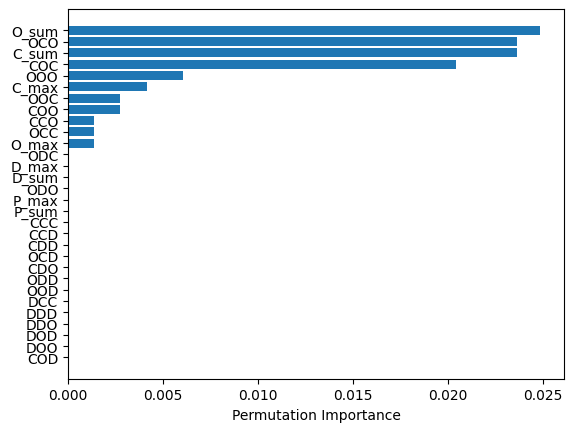

In [32]:
train(file=FILES['training']['labels'])

/home/harsh/ransomware-classifier/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/harsh/ransomware-classifier/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/harsh/ransomware-classifier/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/harsh/ransomware-classifier/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/harsh/ransomware-classifier/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature 

Testing score (ensemble): 0.9843


/home/harsh/ransomware-classifier/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/harsh/ransomware-classifier/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/home/harsh/ransomware-classifier/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/harsh/ransomware-classifier/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


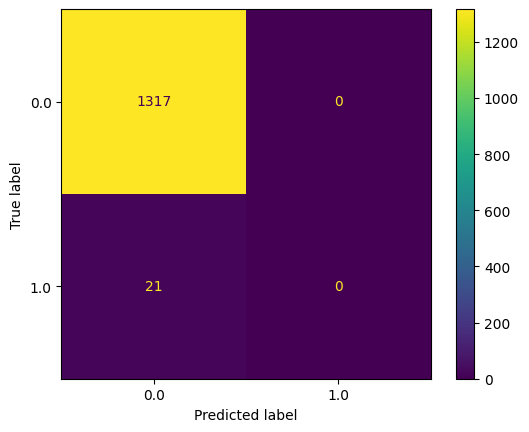

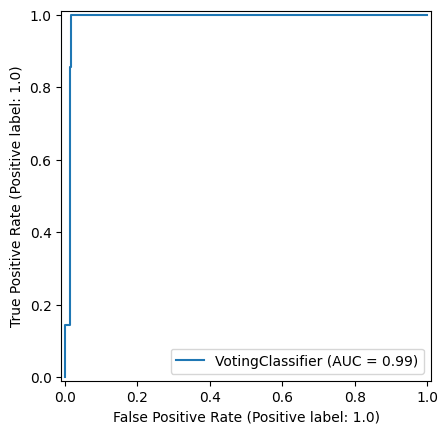

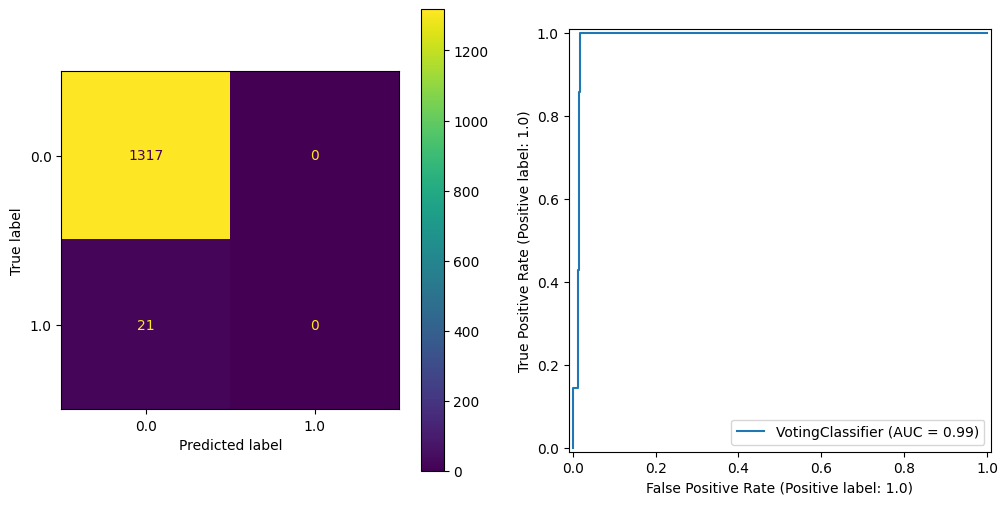

In [33]:
test(file=FILES['testing']['labels'])